In [1]:
import os
import cv2
import torch
import json
from tqdm import tqdm
from IPython.display import Image

from ultralytics import YOLO
from sahi.auto_model import AutoDetectionModel
from sahi.predict import get_sliced_prediction, get_prediction, predict
from sahi.utils.coco import Coco
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.utils.ultralytics import download_yolo11n_model, download_yolo11n_seg_model

/home/long/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Initial training phase

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = YOLO(r"D:\Advanced_Python\Smoker Detection\Implementation\models\yolov5lu.pt")

model.info()

Using device: cuda
YOLOv5l summary: 416 layers, 53,225,024 parameters, 0 gradients, 135.6 GFLOPs


(416, 53225024, 0, 135.62496)

In [ ]:
# model.train(
#     data=r"D:\Advanced_Python\Smoker Detection\Implementation\Smoking-person-1\data.yaml",  
#     epochs=200,           
#     batch=8,            
#     imgsz=640,               
#     device=device,
#     optimizer="AdamW", # important
#     lr0=0.01,
#     weight_decay=0.0005,
#     val=True,
#     resume = False,
#     mosaic = 1, # important
#     half = True
# )

---
## Using SAHI (on 1 instance)

In [3]:
model_path = r"D:\Advanced_Python\Smoker Detection\Implementation\models\yolov11_best.pt"

In [ ]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolo11',
    model_path=model_path,
    confidence_threshold=0.5,
    device="cuda:0", 
)

In [7]:
result = get_sliced_prediction(
    r"D:\Advanced_Python\Smoker Detection\Implementation\Smoking-Detection-3\test\images\3_jpg.rf.79c1e340c5df67cd8e668baf9799a494.jpg",
    detection_model,
    slice_height = 252,
    slice_width = 252,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 9 slices.


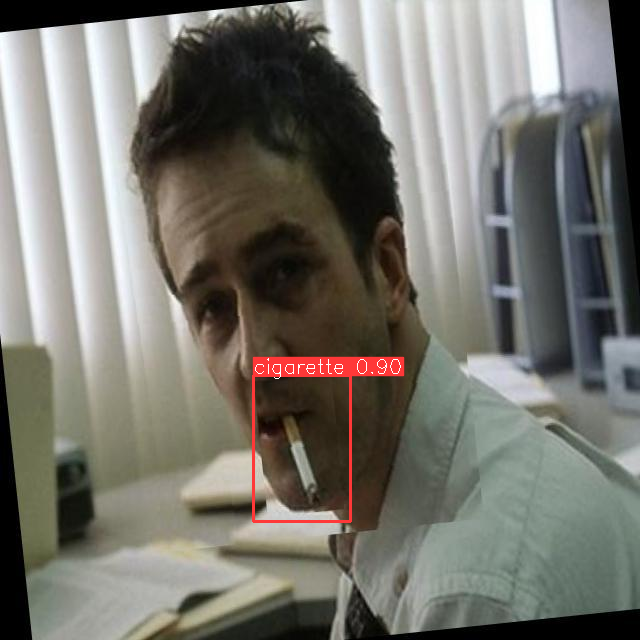

In [8]:
result.export_visuals(export_dir="demo_data_sahi_test/")

Image("demo_data_sahi_test/prediction_visual.png")

---
## Getting predictions on an entire test set

### YOLO

In [ ]:
metrics = model.val(
    data=r"D:\Advanced_Python\Smoker Detection\Implementation\Smoking-person-1\data.yaml", 
    split="test", 
    imgsz=640,
    batch=16, 
    conf=0.3,  
    iou=0.5,  
    device="cuda:0" 
)

### SAHI

In [ ]:
image_folder = r"/home/long/longdata/com vis/data/co aug/test/images" 
output_folder = r"/home/long/longdata/com vis/sahi predicted/co aug"
visualized_folder = r"/home/long/longdata/com vis/sahi predicted/visualized_coaug"

os.makedirs(output_folder, exist_ok=True)
os.makedirs(visualized_folder, exist_ok=True)
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolo11',
    model_path=r"/home/long/longdata/com vis/model-export-luu-o-day/yolov11_best.pt",
    confidence_threshold=0.5,
    device="cuda:0"
)

for filename in tqdm(os.listdir(image_folder)): 
    if filename.endswith(('.jpg')):   
        image_path = os.path.join(image_folder, filename) 
        image = cv2.imread(image_path)
        result = get_sliced_prediction( 
            image_path, 
            detection_model, 
            slice_height=252, 
            slice_width=252, 
            overlap_height_ratio=0.2, 
            overlap_width_ratio=0.2 
        ) 
        
        txt_filename = os.path.splitext(filename)[0] + ".txt" 
        txt_path = os.path.join(output_folder, txt_filename) 

        with open(txt_path, "w") as f: 
            for obj in result.object_prediction_list: 
                category = obj.category.id   
                confidence = float(obj.score.value) 
                x, y, w, h = obj.bbox.to_xywh()
                
                f.write(f"{category} {x} {y} {w} {h} {confidence:.4f}\n")
                
                
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(image, f"{category}: {confidence:.2f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        
        visualized_path = os.path.join(visualized_folder, filename)
        cv2.imwrite(visualized_path, image)

print("Processing complete. Predictions saved in:", output_folder)
print("Visualized images saved in:", visualized_folder)

---
## Real Time

### YOLO

In [ ]:
from ultralytics import YOLO
import cv2

model = YOLO(r"D:\Advanced_Python\Smoker Detection\Implementation\models\yolov11_best.pt")

results = model.predict(source=0, show=True, stream=True)  

cap = cv2.VideoCapture(0)

for result in results:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### SAHI

In [ ]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolo11',
    model_path=r"D:\Advanced_Python\Smoker Detection\Implementation\models\yolov11_best.pt",
    confidence_threshold=0.5,
    device="cuda:0"
)

cap = cv2.VideoCapture(0) 
cap.set(3, 480)  
cap.set(3, 480)  

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Failed to capture frame")
        break

    result = get_sliced_prediction(
        frame,
        detection_model,
        slice_height=320,
        slice_width=320,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2
    )

    for obj in result.object_prediction_list:
        category = obj.category.id
        confidence = float(obj.score.value)
        x, y, w, h = obj.bbox.to_xywh()

        x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        label = f"Class {category}: {confidence:.2f}"
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow("SAHI YOLOv11 Real-Time Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing predictio